In [1]:
import os ##冰激淋+擔擔麵+蜂蜜檸檬適用

os.environ["CUDA_VISIBLE_DEVICES"] = "1" #使用第0張顯卡 ##冰激淋+擔擔麵+蜂蜜檸檬適用 0or1

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Dropout, Flatten, Convolution1D, MaxPooling1D, Activation, BatchNormalization,\
Lambda, Concatenate, Add, Conv2D, Conv1D,TimeDistributed
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from itertools import permutations
from PIL import Image
import matplotlib.pyplot as plt
import psutil
import os
import numpy as np
import pandas as pd
import datetime
import warnings
import pickle
import csv
import random
from keras.models import Sequential
from keras import backend as K

In [4]:
"""
基本設定
"""
n=148335 #用2016 1~3月的資料 288x(31+29+31+30+31+30+...)=52416 210528-1(all) 差值在減一  
l=36 
currency = ["CHF","CAD","GBP","JPY","EUR","HKD"]
currencynum = len(currency)
month = [0,31,60,91,121,152,182,213,244,274,305,335,366,397,425,456,486,517,547,578,609,639,670,700,731] #2016是閏年 366天
daynum = [0,5803,11746,18352,24381,30580,36862,42796,49202,55343,61231,67401,73733,79985,85727,92344,98128,104693,111029,117077,123701,129808,136084,142402,148336]
#currency = ["BTC","DASH","ETH","LTC","JBY","GBP","EUR","AUD","US"]
question = ["trand","volatility"]
# 貨幣組合，1 : P, 0 : C
M=0

epochs = 45
batch_size = 4096

all_cur_pair = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
if(M==0):
    all_cur_pair_P = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
elif(M==1):
    all_cur_pair_P = list(permutations(currency,2))# (Pn取2) 問題有先後順序時使用  
all_question= list(permutations(question,1))
np.set_printoptions(suppress=True)#不要用科學符號輸出

In [5]:
"""""""""
str, onehotcode, company code轉換
"""""""""
currencylist = {}
questionlist = {}
for i in range(len(currency)):
    currencylist[i] = currency[i]

for i in range(len(question)):
    questionlist[i] = question[i]

def str_to_currency(cur):
    return {v: k for k, v in currencylist.items()}[cur]

def str_to_question(q):
    return {v: k for k, v in questionlist.items()}[q]


def one_hot_currency(currencylist):
    d = {}
    temp = np.eye((len(currencylist)))
    for i in range(len(currencylist)):
        d[i] = temp[i]
    return d

def one_hot_question(questionlist):
    d = {}
    temp = np.eye((len(questionlist)))
    for i in range(len(questionlist)):
        d[i] = temp[i]
    return d

onehotcurrency = one_hot_currency(currencylist)
onehotquestion = one_hot_question(questionlist)

In [6]:
"""
Q&A
"""
vol='volatility'
def set_question(com1, com2, typeq):

    return np.concatenate((onehotquestion[str_to_question(typeq)],onehotcurrency[str_to_currency(com1)], onehotcurrency[str_to_currency(com2)]))

qtype = ['big']
HVqtype = ['big']

"""比漲幅程度類問題"""
def set_question_and_answer_pair(data, data2, n, all_cur_pair_P): #比較波動率大小的問題
    q_pair = {}
    a_pair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    #data_sum=np.sum(data,axis=1)
    data2_sum=np.sum(data2,axis=1)
    outcome[0]=(data2_sum[0])
    outcome[1]=(data2_sum[1])
    outcome[2]=(data2_sum[2])
    outcome[3]=(data2_sum[3])
    outcome[4]=(data2_sum[4])
    outcome[5]=(data2_sum[5])

    tmp_q = []
    tmp_a = []
    for j in range(len(all_cur_pair_P)):
        tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1],all_question[0][0]))
    q_pair[i] = tmp_q        
    for j in range(len(all_cur_pair_P)):
        if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
            tmp_a.append(1)
        else:
            tmp_a.append(0)
    a_pair[i] = tmp_a
    return (data, q_pair, a_pair)


"""History Volatility類問題"""
def set_HVquestion_and_HVanswer_pair(data, data2,all_cur_pair_P): #比較波動率大小的問題
    q_HVpair = {}
    a_HVpair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    data2_std=np.std(data2,axis=1) 
    outcome[0]=data2_std[0]
    outcome[1]=data2_std[1]
    outcome[2]=data2_std[2]
    outcome[3]=data2_std[3]
    outcome[4]=data2_std[4]
    outcome[5]=data2_std[5]     

    tmp_q = []
    tmp_a = []   
    for j in range(len(all_cur_pair_P)):
        tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1],all_question[1][0]))
    q_HVpair[i] = tmp_q
    for j in range(len(all_cur_pair_P)):
        if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
            tmp_a.append(1)
        else:
            tmp_a.append(0)
                
    a_HVpair[i] = tmp_a    
    return (data, q_HVpair, a_HVpair)

In [7]:
"""
網路函數
"""
def ConvolutionNetworks(filter_num,kernel_size):
    def conv(model):
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = (MaxPooling1D(pool_size=5))(model)
        model = BatchNormalization()(model)
        return model
    return conv

def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y

def build_tag(conv):
    d = K.int_shape(conv)[1]
    tag = np.zeros((d,1))
    for i in range(d):
        tag[i] = float(int(i%d))/(d-1)*2-1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)

In [8]:
"""
rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(0,m3-m1-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print("[Training model......]")

    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    
    history = model.fit([Train_v, Train_q], Train_a, validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    cycle = ((currencynum*(currencynum-1))/2)*len(question)*len(qtype)
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==cycle):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==cycle):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])

    print("reverse section--------------------------------------------------------------------------")
    Test_q_reverse=Test_q
    temp=Test_q_reverse[:,2:8]
    Test_q_reverse[:,2:8]=Test_q_reverse[:,8:14]
    Test_q_reverse[:,8:14]=temp
    Test_a_reverse=-1*Test_a+1
    pred = model.predict([Test_v, Test_q_reverse])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a_reverse[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q_reverse[ii])
            a_trend.append(Test_a_reverse[ii])
            trend_count=trend_count+1
            if(trend_count==cycle):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q_reverse[ii])
            a_vol.append(Test_a_reverse[ii])
            vol_count=vol_count+1
            if(vol_count==cycle):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])
    
    """
    benchmark1
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("猜答案多的那邊 benchacc1:")
    print(benchacc)

    """
    benchmark2
    """
    #第一個直接猜1
    benchacc=0
    for i in range(Test_a.shape[0]-1):
        if(Test_a[i]!=Test_a[i+1]):
            benchacc=benchacc+1
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("參考前一個答案 benchacc2:")
    print(benchacc)    
    
    """
    畫圖
    """
    benchfunction=np.ones(a.shape[0])
    benchfunction=benchfunction*benchacc
    plt.plot(history.history['loss'], label='train')
    lastepoch_train_loss.append(history.history['loss'][-1])
    plt.plot(history.history['val_loss'], label='test')
    lastepoch_test_loss.append(history.history['val_loss'][-1])
    print("loss:")
    print(history.history['loss'][-1])
    print("val_loss:")
    print(history.history['val_loss'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['acc'], label='train')
    lastepoch_train_acc.append(history.history['acc'][-1])
    plt.plot(history.history['val_acc'], label='test')
    lastepoch_test_acc.append(history.history['val_acc'][-1])  
    plt.plot(np.arange(epochs),np.repeat(benchacc,epochs), label='benchmark')
    print("acc:")
    print(history.history['acc'][-1])
    print("val_acc:")
    print(history.history['val_acc'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("acc") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
12
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1202 MiB, count=2, average=601 MiB
[Training model......]
Train on 556170 samples, validate on 171360 samples
Epoch 1/20
556170/556170 [==============================] - 7s 13us/step - loss: 0.7257 - acc: 0.5302 - val_loss: 0.6758 - val_acc: 0.5684
Epoch 2/20
556170/556170 [==============================] - 4s 7us/step - loss: 0.6865 - acc: 0.5515 - val_loss: 0.6679 - val_acc: 0.5814
Epoch 3/20
556170/556170 [==============================] - 3s 6us/step - loss: 0.6743 - acc: 0.5698 - val_loss: 0.6607 - val_acc: 0.5926
Epoch 4/20
556170/556170 [==============================] - 3s 6us/step - loss: 0.6656 - acc: 0.5819 - val_loss: 0.6554 - val_acc: 0.5992
Epoch 5/20
556170/556170 [==============================] - 4s 6us/step - loss: 0.6585 - acc: 0.5911 - val_loss: 0.6514 - val_acc: 0.6006
Epoch 6/20
556170/556170 [==============

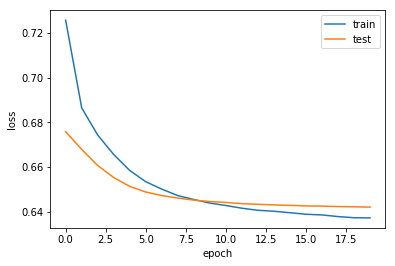

acc:
0.6127263246426736
val_acc:
0.6036998129358478


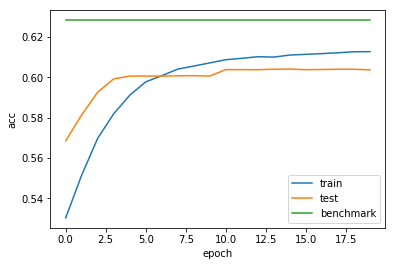

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1218 MiB, count=88, average=13.8 MiB
[Training model......]
Train on 542130 samples, validate on 194790 samples
Epoch 1/20
542130/542130 [==============================] - 7s 12us/step - loss: 0.6973 - acc: 0.5264 - val_loss: 0.6801 - val_acc: 0.5577
Epoch 2/20
542130/542130 [==============================] - 4s 7us/step - loss: 0.6796 - acc: 0.5561 - val_loss: 0.6690 - val_acc: 0.5842
Epoch 3/20
542130/542130 [==============================] - 4s 8us/step - loss: 0.6668 - acc: 0.5756 - val_loss: 0.6565 - val_acc: 0.5845
Epoch 4/20
542130/542130 [==============================] - 4s 7us/step - loss: 0.6578 - acc: 0.5883 - val_loss: 0.6497 - val_acc: 0.5974
Epoch 5/20
542130/542130 [==============================] - 4s 7us/step - loss: 0.6526 - acc: 0.5965 - val_loss: 0.6461 - val_acc: 0.6072
Epoch 6/20
542130/542130 [============

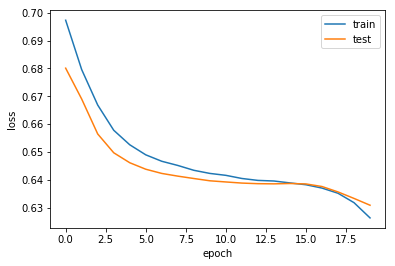

acc:
0.611609761454321
val_acc:
0.6095436111950117


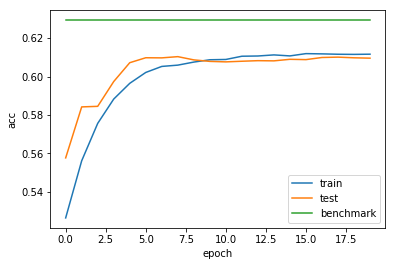

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
14
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1247 MiB, count=89, average=14.0 MiB
[Training model......]
Train on 566820 samples, validate on 187920 samples
Epoch 1/20
566820/566820 [==============================] - 7s 13us/step - loss: 0.7249 - acc: 0.5062 - val_loss: 0.6825 - val_acc: 0.5417
Epoch 2/20
566820/566820 [==============================] - 4s 6us/step - loss: 0.6881 - acc: 0.5407 - val_loss: 0.6729 - val_acc: 0.5660
Epoch 3/20
566820/566820 [==============================] - 4s 7us/step - loss: 0.6730 - acc: 0.5672 - val_loss: 0.6629 - val_acc: 0.5906
Epoch 4/20
566820/566820 [==============================] - 4s 6us/step - loss: 0.6620 - acc: 0.5855 - val_loss: 0.6550 - val_acc: 0.5971
Epoch 5/20
566820/566820 [==============================] - 4s 6us/step - loss: 0.6536 - acc: 0.5984 - val_loss: 0.6504 - val_acc: 0.5989
Epoch 6/20
566820/566820 [============

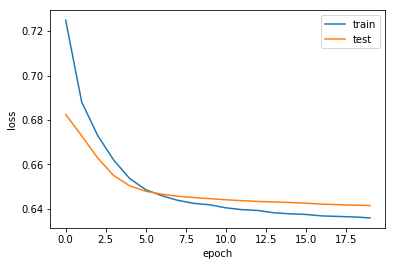

acc:
0.6143502346465971
val_acc:
0.6003086424523488


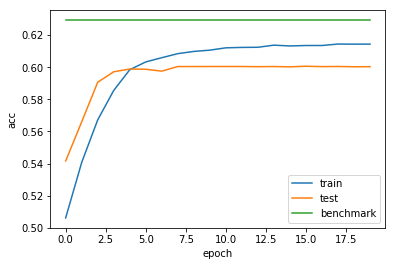

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1219 MiB, count=90, average=13.5 MiB
[Training model......]
Train on 558390 samples, validate on 179280 samples
Epoch 1/20
558390/558390 [==============================] - 7s 13us/step - loss: 0.7443 - acc: 0.5089 - val_loss: 0.6812 - val_acc: 0.5496
Epoch 2/20
558390/558390 [==============================] - 4s 7us/step - loss: 0.6919 - acc: 0.5332 - val_loss: 0.6718 - val_acc: 0.5722
Epoch 3/20
558390/558390 [==============================] - 4s 7us/step - loss: 0.6778 - acc: 0.5512 - val_loss: 0.6638 - val_acc: 0.5894
Epoch 4/20
558390/558390 [==============================] - 4s 7us/step - loss: 0.6674 - acc: 0.5659 - val_loss: 0.6570 - val_acc: 0.5867
Epoch 5/20
558390/558390 [==============================] - 4s 6us/step - loss: 0.6605 - acc: 0.5758 - val_loss: 0.6531 - val_acc: 0.5969
Epoch 6/20
558390/558390 [============

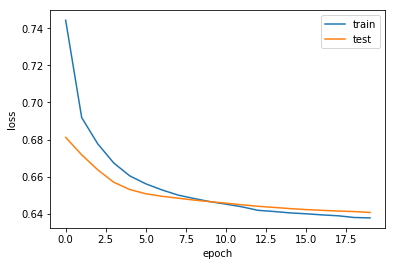

acc:
0.6112143841820769
val_acc:
0.6041722450496788


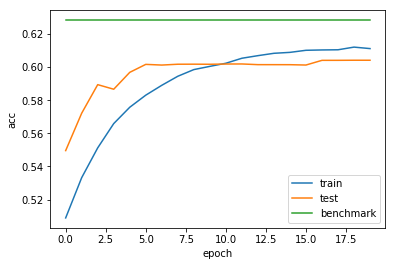

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1261 MiB, count=91, average=13.9 MiB
[Training model......]
Train on 566310 samples, validate on 196560 samples
Epoch 1/20
566310/566310 [==============================] - 8s 14us/step - loss: 0.7039 - acc: 0.5147 - val_loss: 0.6792 - val_acc: 0.5606
Epoch 2/20
566310/566310 [==============================] - 4s 7us/step - loss: 0.6806 - acc: 0.5559 - val_loss: 0.6680 - val_acc: 0.5898
Epoch 3/20
566310/566310 [==============================] - 4s 6us/step - loss: 0.6694 - acc: 0.5791 - val_loss: 0.6604 - val_acc: 0.5970
Epoch 4/20
566310/566310 [==============================] - 4s 7us/step - loss: 0.6628 - acc: 0.5901 - val_loss: 0.6561 - val_acc: 0.6007
Epoch 5/20
566310/566310 [==============================] - 4s 7us/step - loss: 0.6575 - acc: 0.5974 - val_loss: 0.6530 - val_acc: 0.6024
Epoch 6/20
566310/566310 [============

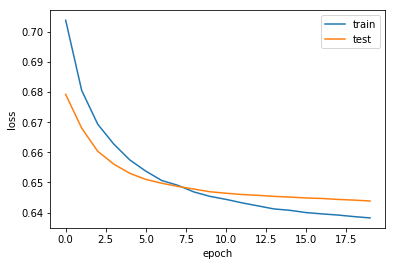

acc:
0.6131871236046136
val_acc:
0.599974563008263


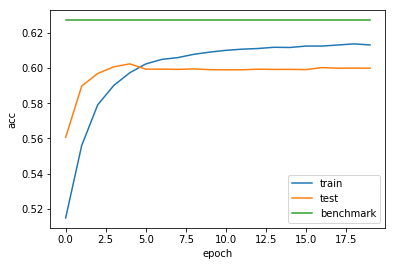

In [9]:
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []
head = 12
tail = 17
for z in range(head,tail,1):
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('data/JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    jpy5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        jpy5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eur5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eur5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CHF_data_ver2.0.csv',header=None)  # 讀取訓練數據
    chf5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        chf5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CAD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    cad5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        cad5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/GBP_data_ver2.0.csv',header=None)  # 讀取訓練數據
    gbp5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        gbp5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/HKD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    hkd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        hkd5months[dt] = df[0][i]  
        dt=dt+1
    print('finish dataread')
    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=chf5months[p:p+l]
        Train_data[p,1,:]=cad5months[p:p+l]
        Train_data[p,2,:]=gbp5months[p:p+l]
        Train_data[p,3,:]=jpy5months[p:p+l]
        Train_data[p,4,:]=eur5months[p:p+l]
        Train_data[p,5,:]=hkd5months[p:p+l]
    
    MLP_unit=64
    visual_scene = Input((l,currencynum))
    visual_conv = ConvolutionNetworks(20,5)(visual_scene)
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([visual_conv, tag])
    shapes = visual_conv.shape
    w = shapes[1]
    features= []
    for k1 in range(w):
        def get_feature(t):
            return t[:, k1, :]
        get_feature_layer = Lambda(get_feature)
        features.append(get_feature_layer(visual_conv))

    input2 = Input((14,))
    onehot_encode = input2   

    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode]))    


    g_MLP = get_MLP(5, get_dense(5,MLP_unit))
    f_MLP = get_MLP(5, get_dense(5,MLP_unit))
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))

    combined_relation = Add()(mid_relations)

    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')

    pred = Dense(1, activation = 'sigmoid')(rn)

    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(z)
    fit_show(Train_data,daynum[z],daynum[z+3],daynum[z+4])
    

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 36, 6)        0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 32, 20)       620         input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 28, 20)       2020        conv1d_13[0][0]                  
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 24, 20)       2020        conv1d_14[0][0]                  
__________________________________________________________________________________________________
max_poolin

train_acc:red,test_acc:blue


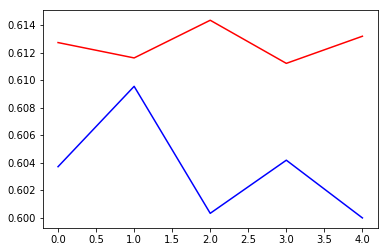

train_loss:red,test_loss:blue


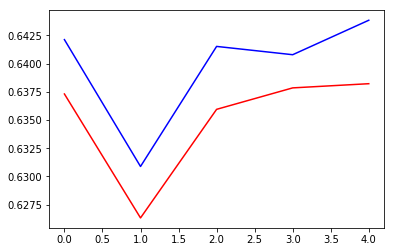

trend:red,vol:blue


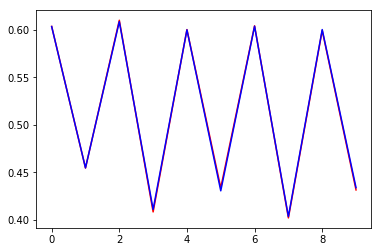

In [11]:
print("train_acc:red,test_acc:blue")    
plt.plot(lastepoch_train_acc,color='r')
plt.plot(lastepoch_test_acc,color='b')
plt.show()
print("train_loss:red,test_loss:blue")
plt.plot(lastepoch_train_loss,color='r')
plt.plot(lastepoch_test_loss,color='b')
plt.show()
print("trend:red,vol:blue")
plt.plot(total_test_trend,color='r')
plt.plot(total_test_vol,color='b')
plt.show()

In [12]:
K.clear_session()

In [8]:
"""
rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(0,m3-m1-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print("[Training model......]")

    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    
    history = model.fit([Train_v, Train_q], Train_a, validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    cycle = ((currencynum*(currencynum-1))/2)*len(question)*len(qtype)
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==cycle):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==cycle):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])

    print("reverse section--------------------------------------------------------------------------")
    Test_q_reverse=Test_q
    temp=Test_q_reverse[:,2:8]
    Test_q_reverse[:,2:8]=Test_q_reverse[:,8:14]
    Test_q_reverse[:,8:14]=temp
    Test_a_reverse=-1*Test_a+1
    pred = model.predict([Test_v, Test_q_reverse])
    count = 0
    print(pred)

    """
    benchmark1
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("猜答案多的那邊 benchacc1:")
    print(benchacc)

    """
    benchmark2
    """
    #第一個直接猜1
    benchacc=0
    for i in range(Test_a.shape[0]-1):
        if(Test_a[i]!=Test_a[i+1]):
            benchacc=benchacc+1
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("參考前一個答案 benchacc2:")
    print(benchacc)    
    


In [9]:
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []
head = 9
tail = 21
for z in range(head,tail,1):
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('data/JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    jpy5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        jpy5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eur5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eur5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CHF_data_ver2.0.csv',header=None)  # 讀取訓練數據
    chf5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        chf5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CAD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    cad5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        cad5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/GBP_data_ver2.0.csv',header=None)  # 讀取訓練數據
    gbp5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        gbp5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/HKD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    hkd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        hkd5months[dt] = df[0][i]  
        dt=dt+1
    print('finish dataread')
    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=chf5months[p:p+l]
        Train_data[p,1,:]=cad5months[p:p+l]
        Train_data[p,2,:]=gbp5months[p:p+l]
        Train_data[p,3,:]=jpy5months[p:p+l]
        Train_data[p,4,:]=eur5months[p:p+l]
        Train_data[p,5,:]=hkd5months[p:p+l]
    
    MLP_unit=64
    visual_scene = Input((l,currencynum))
    visual_conv = ConvolutionNetworks(20,5)(visual_scene)
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([visual_conv, tag])
    shapes = visual_conv.shape
    w = shapes[1]
    features= []
    for k1 in range(w):
        def get_feature(t):
            return t[:, k1, :]
        get_feature_layer = Lambda(get_feature)
        features.append(get_feature_layer(visual_conv))

    input2 = Input((14,))
    onehot_encode = input2   

    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode]))    


    g_MLP = get_MLP(5, get_dense(5,MLP_unit))
    f_MLP = get_MLP(5, get_dense(5,MLP_unit))
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))

    combined_relation = Add()(mid_relations)

    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')

    pred = Dense(1, activation = 'sigmoid')(rn)

    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(z)
    fit_show(Train_data,daynum[z],daynum[z+3],daynum[z+4])

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
9
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1215 MiB, count=2, average=607 MiB
[Training model......]
Train on 549540 samples, validate on 185400 samples
Epoch 1/45
549540/549540 [==============================] - 7s 13us/step - loss: 0.7099 - acc: 0.5143 - val_loss: 0.6806 - val_acc: 0.5833
Epoch 2/45
549540/549540 [==============================] - 4s 7us/step - loss: 0.6871 - acc: 0.5445 - val_loss: 0.6728 - val_acc: 0.5946
Epoch 3/45
549540/549540 [==============================] - 4s 7us/step - loss: 0.6781 - acc: 0.5629 - val_loss: 0.6629 - val_acc: 0.5947
Epoch 4/45
549540/549540 [==============================] - 3s 6us/step - loss: 0.6695 - acc: 0.5765 - val_loss: 0.6526 - val_acc: 0.6062
Epoch 5/45
549540/549540 [==============================] - 4s 7us/step - loss: 0.6618 - acc: 0.5887 - val_loss: 0.6458 - val_acc: 0.6153
Epoch 6/45
549540/549540 [===============

Epoch 8/45
560460/560460 [==============================] - 4s 7us/step - loss: 0.6524 - acc: 0.6004 - val_loss: 0.6395 - val_acc: 0.6073
Epoch 9/45
560460/560460 [==============================] - 4s 6us/step - loss: 0.6505 - acc: 0.6014 - val_loss: 0.6378 - val_acc: 0.6075
Epoch 10/45
560460/560460 [==============================] - 4s 6us/step - loss: 0.6486 - acc: 0.6028 - val_loss: 0.6368 - val_acc: 0.6078
Epoch 11/45
560460/560460 [==============================] - 4s 7us/step - loss: 0.6473 - acc: 0.6040 - val_loss: 0.6357 - val_acc: 0.6081
Epoch 12/45
560460/560460 [==============================] - 4s 7us/step - loss: 0.6460 - acc: 0.6040 - val_loss: 0.6352 - val_acc: 0.6076
Epoch 13/45
560460/560460 [==============================] - 4s 6us/step - loss: 0.6451 - acc: 0.6060 - val_loss: 0.6347 - val_acc: 0.6076
Epoch 14/45
560460/560460 [==============================] - 4s 7us/step - loss: 0.6443 - acc: 0.6064 - val_loss: 0.6343 - val_acc: 0.6074
Epoch 15/45
560460/560460 [==

Epoch 17/45
547620/547620 [==============================] - 4s 6us/step - loss: 0.6432 - acc: 0.6068 - val_loss: 0.6336 - val_acc: 0.6048
Epoch 18/45
547620/547620 [==============================] - 4s 7us/step - loss: 0.6428 - acc: 0.6070 - val_loss: 0.6334 - val_acc: 0.6054
Epoch 19/45
547620/547620 [==============================] - 4s 7us/step - loss: 0.6425 - acc: 0.6065 - val_loss: 0.6328 - val_acc: 0.6058
Epoch 20/45
547620/547620 [==============================] - 4s 7us/step - loss: 0.6423 - acc: 0.6068 - val_loss: 0.6324 - val_acc: 0.6092
Epoch 21/45
547620/547620 [==============================] - 4s 7us/step - loss: 0.6418 - acc: 0.6065 - val_loss: 0.6317 - val_acc: 0.6093
Epoch 22/45
547620/547620 [==============================] - 4s 7us/step - loss: 0.6417 - acc: 0.6062 - val_loss: 0.6319 - val_acc: 0.6092
Epoch 23/45
547620/547620 [==============================] - 4s 7us/step - loss: 0.6412 - acc: 0.6082 - val_loss: 0.6315 - val_acc: 0.6093
Epoch 24/45
547620/547620 [

Epoch 26/45
556170/556170 [==============================] - 4s 6us/step - loss: 0.6417 - acc: 0.6071 - val_loss: 0.6323 - val_acc: 0.6067
Epoch 27/45
556170/556170 [==============================] - 4s 7us/step - loss: 0.6416 - acc: 0.6075 - val_loss: 0.6323 - val_acc: 0.6067
Epoch 28/45
556170/556170 [==============================] - 4s 7us/step - loss: 0.6413 - acc: 0.6076 - val_loss: 0.6322 - val_acc: 0.6068
Epoch 29/45
556170/556170 [==============================] - 4s 6us/step - loss: 0.6410 - acc: 0.6078 - val_loss: 0.6318 - val_acc: 0.6064
Epoch 30/45
556170/556170 [==============================] - 4s 7us/step - loss: 0.6406 - acc: 0.6074 - val_loss: 0.6319 - val_acc: 0.6064
Epoch 31/45
556170/556170 [==============================] - 4s 6us/step - loss: 0.6404 - acc: 0.6076 - val_loss: 0.6316 - val_acc: 0.6065
Epoch 32/45
556170/556170 [==============================] - 4s 7us/step - loss: 0.6405 - acc: 0.6075 - val_loss: 0.6314 - val_acc: 0.6066
Epoch 33/45
556170/556170 [

Epoch 35/45
542130/542130 [==============================] - 3s 6us/step - loss: 0.6257 - acc: 0.6074 - val_loss: 0.6110 - val_acc: 0.6032
Epoch 36/45
542130/542130 [==============================] - 4s 7us/step - loss: 0.6206 - acc: 0.6083 - val_loss: 0.6075 - val_acc: 0.6059
Epoch 37/45
542130/542130 [==============================] - 4s 7us/step - loss: 0.6149 - acc: 0.6105 - val_loss: 0.6043 - val_acc: 0.6090
Epoch 38/45
542130/542130 [==============================] - 3s 6us/step - loss: 0.6098 - acc: 0.6122 - val_loss: 0.6013 - val_acc: 0.6108
Epoch 39/45
542130/542130 [==============================] - 4s 7us/step - loss: 0.6056 - acc: 0.6152 - val_loss: 0.6000 - val_acc: 0.6116
Epoch 40/45
542130/542130 [==============================] - 3s 6us/step - loss: 0.6021 - acc: 0.6197 - val_loss: 0.5993 - val_acc: 0.6131
Epoch 41/45
542130/542130 [==============================] - 4s 7us/step - loss: 0.5988 - acc: 0.6255 - val_loss: 0.5991 - val_acc: 0.6131
Epoch 42/45
542130/542130 [

Epoch 44/45
566820/566820 [==============================] - 4s 7us/step - loss: 0.6377 - acc: 0.6087 - val_loss: 0.6247 - val_acc: 0.6127
Epoch 45/45
566820/566820 [==============================] - 4s 7us/step - loss: 0.6366 - acc: 0.6084 - val_loss: 0.6235 - val_acc: 0.6132
[[0.48691627]
 [0.5039703 ]
 [0.47734463]
 ...
 [0.5735683 ]
 [0.66864276]
 [0.7217432 ]]
115234 0.6132077479778629
trend_test_acc:
57445 0.6113771817794806
vol_test_acc:
57789 0.6150383141762452
reverse section--------------------------------------------------------------------------
[[0.48861814]
 [0.42195818]
 [0.4392728 ]
 ...
 [0.5151991 ]
 [0.61345625]
 [0.61345625]]
猜答案多的那邊 benchacc1:
0.539734993614304
參考前一個答案 benchacc2:
0.6187100893997446
(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2467 MiB, count=94, average=26.2 MiB
[Training model......]
Train on 558390 samples, validate on 179280 samples


566310/566310 [==============================] - 4s 7us/step - loss: 0.6839 - acc: 0.5516 - val_loss: 0.6637 - val_acc: 0.6209
Epoch 3/45
566310/566310 [==============================] - 4s 6us/step - loss: 0.6700 - acc: 0.5776 - val_loss: 0.6508 - val_acc: 0.6323
Epoch 4/45
566310/566310 [==============================] - 4s 7us/step - loss: 0.6620 - acc: 0.5901 - val_loss: 0.6437 - val_acc: 0.6248
Epoch 5/45
566310/566310 [==============================] - 4s 7us/step - loss: 0.6576 - acc: 0.5954 - val_loss: 0.6402 - val_acc: 0.6161
Epoch 6/45
566310/566310 [==============================] - 4s 7us/step - loss: 0.6546 - acc: 0.5992 - val_loss: 0.6380 - val_acc: 0.6161
Epoch 7/45
566310/566310 [==============================] - 4s 6us/step - loss: 0.6526 - acc: 0.6011 - val_loss: 0.6368 - val_acc: 0.6166
Epoch 8/45
566310/566310 [==============================] - 4s 7us/step - loss: 0.6508 - acc: 0.6023 - val_loss: 0.6360 - val_acc: 0.6168
Epoch 9/45
566310/566310 [===================

Epoch 11/45
568080/568080 [==============================] - 4s 7us/step - loss: 0.6449 - acc: 0.6064 - val_loss: 0.6332 - val_acc: 0.6105
Epoch 12/45
568080/568080 [==============================] - 4s 7us/step - loss: 0.6444 - acc: 0.6059 - val_loss: 0.6331 - val_acc: 0.6105
Epoch 13/45
568080/568080 [==============================] - 4s 7us/step - loss: 0.6439 - acc: 0.6069 - val_loss: 0.6328 - val_acc: 0.6106
Epoch 14/45
568080/568080 [==============================] - 4s 7us/step - loss: 0.6433 - acc: 0.6057 - val_loss: 0.6325 - val_acc: 0.6107
Epoch 15/45
568080/568080 [==============================] - 4s 6us/step - loss: 0.6428 - acc: 0.6062 - val_loss: 0.6325 - val_acc: 0.6111
Epoch 16/45
568080/568080 [==============================] - 4s 7us/step - loss: 0.6426 - acc: 0.6066 - val_loss: 0.6325 - val_acc: 0.6110
Epoch 17/45
568080/568080 [==============================] - 4s 6us/step - loss: 0.6422 - acc: 0.6074 - val_loss: 0.6323 - val_acc: 0.6107
Epoch 18/45
568080/568080 [

Epoch 20/45
561210/561210 [==============================] - 3s 6us/step - loss: 0.6425 - acc: 0.6073 - val_loss: 0.6310 - val_acc: 0.6151
Epoch 21/45
561210/561210 [==============================] - 4s 7us/step - loss: 0.6423 - acc: 0.6070 - val_loss: 0.6310 - val_acc: 0.6150
Epoch 22/45
561210/561210 [==============================] - 4s 7us/step - loss: 0.6420 - acc: 0.6074 - val_loss: 0.6309 - val_acc: 0.6151
Epoch 23/45
561210/561210 [==============================] - 4s 7us/step - loss: 0.6417 - acc: 0.6077 - val_loss: 0.6306 - val_acc: 0.6148
Epoch 24/45
561210/561210 [==============================] - 4s 6us/step - loss: 0.6416 - acc: 0.6078 - val_loss: 0.6306 - val_acc: 0.6145
Epoch 25/45
561210/561210 [==============================] - 4s 7us/step - loss: 0.6410 - acc: 0.6082 - val_loss: 0.6304 - val_acc: 0.6149
Epoch 26/45
561210/561210 [==============================] - 4s 7us/step - loss: 0.6411 - acc: 0.6081 - val_loss: 0.6304 - val_acc: 0.6141
Epoch 27/45
561210/561210 [

Epoch 29/45
568050/568050 [==============================] - 4s 7us/step - loss: 0.6412 - acc: 0.6074 - val_loss: 0.6295 - val_acc: 0.6168
Epoch 30/45
568050/568050 [==============================] - 4s 7us/step - loss: 0.6410 - acc: 0.6071 - val_loss: 0.6297 - val_acc: 0.6162
Epoch 31/45
568050/568050 [==============================] - 4s 7us/step - loss: 0.6408 - acc: 0.6077 - val_loss: 0.6292 - val_acc: 0.6161
Epoch 32/45
568050/568050 [==============================] - 4s 7us/step - loss: 0.6405 - acc: 0.6083 - val_loss: 0.6285 - val_acc: 0.6162
Epoch 33/45
568050/568050 [==============================] - 4s 7us/step - loss: 0.6399 - acc: 0.6082 - val_loss: 0.6289 - val_acc: 0.6161
Epoch 34/45
568050/568050 [==============================] - 4s 7us/step - loss: 0.6399 - acc: 0.6081 - val_loss: 0.6278 - val_acc: 0.6157
Epoch 35/45
568050/568050 [==============================] - 4s 7us/step - loss: 0.6398 - acc: 0.6077 - val_loss: 0.6278 - val_acc: 0.6160
Epoch 36/45
568050/568050 [

Epoch 38/45
558870/558870 [==============================] - 4s 7us/step - loss: 0.6389 - acc: 0.6080 - val_loss: 0.6247 - val_acc: 0.6100
Epoch 39/45
558870/558870 [==============================] - 4s 7us/step - loss: 0.6386 - acc: 0.6075 - val_loss: 0.6237 - val_acc: 0.6100
Epoch 40/45
558870/558870 [==============================] - 4s 7us/step - loss: 0.6383 - acc: 0.6082 - val_loss: 0.6226 - val_acc: 0.6098
Epoch 41/45
558870/558870 [==============================] - 4s 7us/step - loss: 0.6382 - acc: 0.6076 - val_loss: 0.6218 - val_acc: 0.6096
Epoch 42/45
558870/558870 [==============================] - 4s 6us/step - loss: 0.6381 - acc: 0.6082 - val_loss: 0.6208 - val_acc: 0.6094
Epoch 43/45
558870/558870 [==============================] - 4s 7us/step - loss: 0.6378 - acc: 0.6076 - val_loss: 0.6199 - val_acc: 0.6097
Epoch 44/45
558870/558870 [==============================] - 4s 7us/step - loss: 0.6372 - acc: 0.6078 - val_loss: 0.6187 - val_acc: 0.6096
Epoch 45/45
558870/558870 [